In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


import KSEM
from importlib import reload  
KSEM = reload(KSEM)
from KSEM import KSQS
from KSEM import EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub="ibm-q-pnnl", group="internal", project="default")
name = "ibmq_brooklyn"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

n_qubits = 3
reps = 8
max_num_itrs = 12

In [4]:
# backend.properties().to_dict()

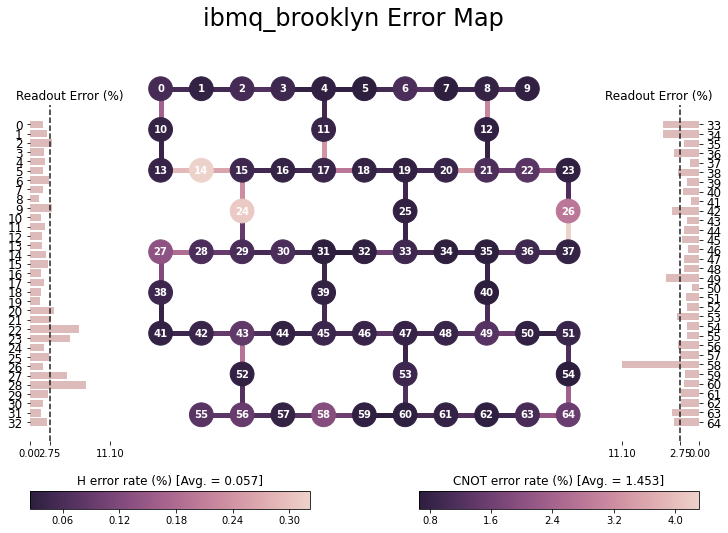

In [5]:
from qiskit.visualization import plot_error_map, plot_gate_map
%matplotlib inline

plot_error_map(backend)

In [6]:
from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.ccx(0,1,2)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
#     total_circ.measure_all()
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    return total_circ

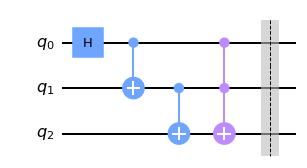

In [7]:
single_iter(n_qubits).draw("mpl")

18


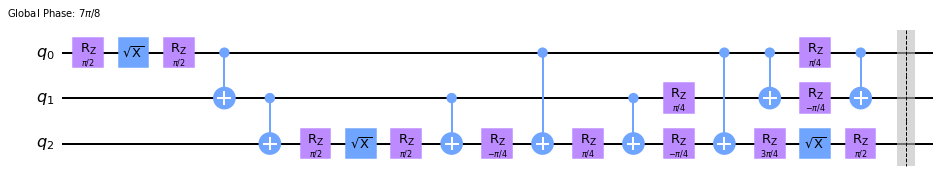

In [8]:
temp_circ = transpile(single_iter(n_qubits), backend=den_simu)
print(temp_circ.depth())
temp_circ.draw("mpl")

In [9]:
temp_circ2 = iterative_circ(max_num_itrs, n_qubits, save_den = False)
temp_circ3 = transpile(temp_circ2, backend=backend)
print("Depth:", temp_circ3.depth())
print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
dt = backend.configuration().dt # sec
temp_sch = schedule(temp_circ3, backend)
print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

Depth: 303
T1: 0.00010025178679293694 sec
T2: 0.00010019964695396136 sec
Circuit Operation Time: 6.813866666666666e-05 sec


## Qiskit Backend-noise Simulation

Obtain measurement data and actual quantum states (from a backend-noise simulator)

Note that the outputs does not have measurement noise because the probabilities are obtained from density matrix object, instead of measurement operator API.

In [10]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)

In [11]:
np.random.seed(7)


total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    trans_circ = transpile(iterative_circ(i, n_qubits), backend=den_simu)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    total_simu_probs.append(iter_den.probabilities())
    total_simu_purs.append(np.real(iter_den.purity()))
    
print("Purity")
for pu in total_simu_purs:
    print(pu)
    
print("\nProb Vec")
for p in total_simu_probs:
    print(p)

Purity
0.8734221454860687
0.7587499215395922
0.653588184270288
0.5703855558397433
0.5043083867996516
0.4521090899901743
0.40731854513112903
0.37273991141883983
0.3361317067220678
0.3046295491524854
0.27680685195616317
0.25673857638521913

Prob Vec
[0.4868601  0.01348074 0.00792186 0.46644631 0.00530425 0.00641299
 0.00596039 0.00761335]
[0.24951039 0.23238829 0.01598252 0.23714907 0.01511776 0.01307695
 0.22543595 0.01133908]
[0.03756471 0.1330638  0.11794552 0.42456507 0.02213152 0.12025193
 0.12320425 0.02127319]
[0.08998106 0.08227485 0.07724681 0.0849396  0.08790631 0.07473377
 0.43508227 0.06783532]
[0.13299359 0.04077611 0.11928056 0.04314748 0.1337739  0.3632063
 0.12671841 0.04010365]
[0.10015051 0.07667634 0.0827638  0.07929711 0.40322636 0.08732861
 0.08807238 0.08248489]
[0.05803659 0.11555039 0.04896524 0.12213451 0.34581451 0.12596606
 0.05114196 0.13239074]
[0.09688881 0.08414621 0.09398635 0.08241778 0.36553929 0.09197208
 0.08912085 0.09592863]
[0.12334924 0.12144708 0.

## State Tomography

In [12]:
backend_noise_model_for_tomo = NoiseModel.from_backend(backend)
# Remove readout errros
p0given1 = 0
p1given0 = 0
rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
for i in range(backend.configuration().num_qubits):
    backend_noise_model_for_tomo._local_readout_errors[(i,)] = rde
den_simu_for_tomo = AerSimulator(method='density_matrix',noise_model=backend_noise_model_for_tomo)

In [13]:
np.random.seed(7)

tomo_dens = [] # quantum state in density-matrix form
tomo_probs = [] # measurement result
tomo_purs = [] # purity
for i in range(1, max_num_itrs+1):
    tomo_target_circ = transpile(iterative_circ(i, n_qubits, save_den = False), backend=den_simu_for_tomo)
    qstexp = StateTomography(tomo_target_circ)
    qstdata = qstexp.run(den_simu, seed_simulation=np.random.randint(10**8)).block_for_results()
    tomo_state =  qstdata.analysis_results("state")
    
    tomo_dens.append(tomo_state.value.data)
    tomo_probs.append(tomo_state.value.probabilities())
    tomo_purs.append(np.real(tomo_state.value.purity()))
    
print("Tomography Purity")
for pu in tomo_purs:
    print(pu)
    
print("\nTomography Prob Vec")
for p in tomo_probs:
    print(p)

Tomography Purity
0.7573374393600392
0.6258265122661103
0.5587527663619427
0.47883259808575684
0.44458974437949106
0.4023173414630653
0.3604718314276802
0.32345529250156757
0.2977634594764238
0.2761176544942976
0.265186768990976
0.22980868963547707

Tomography Prob Vec
[0.47521635 0.02866416 0.02853367 0.42526791 0.01172378 0.00901551
 0.01031946 0.01125916]
[0.26474337 0.22215436 0.0332221  0.22259966 0.01689147 0.01809958
 0.20715227 0.01513719]
[0.0425076  0.1566569  0.13962131 0.38560655 0.02731662 0.11216905
 0.10424805 0.03187391]
[0.08935547 0.08306207 0.1007487  0.08468967 0.10248481 0.07014974
 0.40131293 0.06819661]
[0.13441298 0.05585395 0.12708876 0.04104275 0.14580621 0.32831489
 0.12318251 0.04429796]
[0.11553277 0.07663303 0.08509657 0.07809787 0.39797635 0.076199
 0.08270942 0.08775499]
[0.07826063 0.11574978 0.05324978 0.1245931  0.32983398 0.12350803
 0.05547418 0.11933051]
[0.11832682 0.08924696 0.09380425 0.08262804 0.33924696 0.08946398
 0.0992296  0.08805339]
[0.1

## Kalman Smoother

In [14]:
def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

### Initialize

In [15]:
initial_state = np.array([0]*(total_simu_probs[0].size**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [16]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = total_simu_probs[0].size

M = np.identity(num_dim_state, dtype=complex)* 0.02 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs, dtype=complex)* 0.1 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.05 * (1+1j)# 
# U = np.identity(num_dim_obs, dtype=complex)* 0.0

In [17]:
x.size,num_dim_state,num_dim_obs, unitaries[0].size

(64, 64, 8, 4096)

### EM and Smoother - Total

Use longest iterations

In [18]:
# total_smoother_dens = []
# total_smoother_purs = []

# observs = total_simu_probs
# learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P, U)
# estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# # Slice from argumented system
# realX0 = estX0.toarray()[:num_dim_state]
# realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
# realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
# realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
# realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
# realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
# realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]
# realU = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs, 2*num_dim_obs)]

# smoother = KSQS(observs, realF, x, realM0, realQ, realR, realP, realU)
# x_seq, M_seq, M_prio_seq = smoother.smooth() 

# x_est_norms = []
# for j in range(max_num_itrs):
#     x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     x_est_norms.append(x_est_norm)
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

Only use the estimation in the final iteration as the valid output

In [37]:
total_smoother_dens = []
total_smoother_purs = []
for i in range(1,max_num_itrs+1):
    observs = total_simu_probs[0:i]
    learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
    estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented
    
    # Slice from argumented system
    realX0 = estX0.toarray()[:num_dim_state]
    realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
    realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
    realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
    realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
    realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
    realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]
    realU = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs, 2*num_dim_obs)]*0

    smoother = KSQS(observs, realF, x, realM0, realQ, realR, realP)
    x_seq, M_seq, M_prio_seq = smoother.smooth() 
    
    # Normalization
    x_est = np.array(x_seq[-1][:num_dim_state].todense()).flatten()
    diag_sum = np.sum(vecden_meas(x_est))

    #normalize along the diagonal
    x_est_norm = x_est+0
    nrows = int(np.sqrt(x_est.size))
    for k in range(nrows):
        x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
    final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)

#     x_est = np.matrix(x_seq[-1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
# #     x_est = (x_est+x_est.H)/2
#     final_den = KSEM.closed_den_mat(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Iteration     1, New log-likelihood 2.26555e+02, Last log-likelihood 2.25814e+02, Change 7.40650e-01
Iteration     2, New log-likelihood 2.23338e+02, Last log-likelihood 2.26555e+02, Change -3.21633e+00
Iteration     1, New log-likelihood 7.05327e+01, Last log-likelihood -1.59486e+00, Change 7.21275e+01
Iteration     2, New log-likelihood -1.98065e+03, Last log-likelihood 7.05327e+01, Change -2.05119e+03
Iteration     1, New log-likelihood -2.79687e+05, Last log-likelihood -5.12469e+03, Change -2.74562e+05
Iteration     1, New log-likelihood -4.29230e+13, Last log-likelihood -1.00827e+05, Change -4.29230e+13
Iteration     1, New log-likelihood -9.45334e+18, Last log-likelihood -1.44617e+06, Change -9.45334e+18
Iteration     1, New log-likelihood -8.78523e+27, Last log-likelihood -1.86864e+07, Change -8.78523e+27
Iteration     1, New log-likelihood -1.44017e+42, Last log-likelihood -2.97401e+08, Change -1.44017e+42
Iteration     1, New log-likelihood -2.19551e+55, Last log-likelihood -5

In [38]:
for den in total_smoother_dens:
    print("Is state a valid density matrix:", qi.DensityMatrix(den).is_valid())

Is state a valid density matrix: False
Is state a valid density matrix: False
Is state a valid density matrix: False
Is state a valid density matrix: False
Is state a valid density matrix: False
Is state a valid density matrix: False
Is state a valid density matrix: False
Is state a valid density matrix: False
Is state a valid density matrix: False
Is state a valid density matrix: False
Is state a valid density matrix: False
Is state a valid density matrix: False


In [39]:
with np.printoptions(precision=3, suppress=True):
#     for den in total_smoother_dens:
#         print(den)
    print(total_smoother_dens[8])

[[ 0.124+0.001j  0.109-0.j     0.013+0.j     0.006+0.j     0.108-0.001j
  -0.105+0.001j  0.022+0.001j  0.216-0.002j]
 [ 0.109-0.j     0.123+0.j    -0.016-0.001j -0.012-0.j     0.108-0.j
  -0.097+0.001j  0.006-0.j     0.208-0.002j]
 [ 0.013+0.j    -0.016-0.001j  0.061+0.001j -0.011-0.j    -0.019-0.j
  -0.002+0.j    -0.007-0.j    -0.019+0.j   ]
 [ 0.006+0.j    -0.012-0.j    -0.011-0.j     0.06 +0.002j -0.012-0.j
  -0.006-0.j     0.014-0.j    -0.003-0.j   ]
 [ 0.108-0.001j  0.108-0.j    -0.019-0.j    -0.012-0.j     0.136-0.j
  -0.077+0.002j -0.015-0.j     0.141-0.003j]
 [-0.105+0.001j -0.097+0.001j -0.002+0.j    -0.006-0.j    -0.077+0.002j
   0.128+0.001j  0.013+0.j    -0.189+0.001j]
 [ 0.022+0.001j  0.006-0.j    -0.007-0.j     0.014-0.j    -0.015-0.j
   0.013+0.j     0.057+0.001j -0.033-0.001j]
 [ 0.216-0.002j  0.208-0.002j -0.019+0.j    -0.003-0.j     0.141-0.003j
  -0.189+0.001j -0.033-0.001j  0.311-0.006j]]


In [40]:
print("Estimated Purity (Total)")
for pu in total_smoother_purs:
    print(pu)

Estimated Purity (Total)
0.9726435808148888
0.9517461621225161
0.9021183237981439
0.8438239449738956
0.7998406327722082
0.7252055056492048
0.667051843915007
0.6320426319797263
0.5951530348044443
0.5565577681574865
0.5462555095766795
0.49771212949736876


## Check the fidelity between estimated state and the real state in the simulator

In [41]:
from scipy.linalg import sqrtm
def state_fid(m1,m2):
    sqm1 = sqrtm(m1)
    temp = sqm1.dot(m2).dot(sqm1)
    temp2 = sqrtm(temp)
    return np.real(np.trace(temp2))**2

In [50]:
# Compare fidelity, use Qiskit API (when every state from KS is a valid density matrix)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    qis_den_tomo = qi.DensityMatrix(tomo_dens[i])
    qis_den_all = qi.DensityMatrix(total_smoother_dens[i])
    fed_difference_tomo =  qi.state_fidelity(total_simu_dens[i], qis_den_tomo)
    fed_difference_all =  qi.state_fidelity(total_simu_dens[i], qis_den_all)
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig("diff_fed_qis.svg")
plt.show()

QiskitError: 'Input quantum state is not a valid'

Iteration 1 KS Fid: 0.9925338505843855 Tomo Fid: 0.9439267525385654
Iteration 2 KS Fid: 0.9689574168714937 Tomo Fid: 0.9383351683741674
Iteration 3 KS Fid: 0.9722995745129427 Tomo Fid: 0.9580231381378862
Iteration 4 KS Fid: 0.963082401049309 Tomo Fid: 0.9733777310343678
Iteration 5 KS Fid: 0.9554438106096184 Tomo Fid: 0.9762134749754922
Iteration 6 KS Fid: 0.9290126839821596 Tomo Fid: 0.9771815180958915
Iteration 7 KS Fid: 0.9358507240073527 Tomo Fid: 0.9795060876865785
Iteration 8 KS Fid: 0.927775251755228 Tomo Fid: 0.9819848464638404
Iteration 9 KS Fid: 0.9199480421966532 Tomo Fid: 0.9818183362758724
Iteration 10 KS Fid: 0.905256293109139 Tomo Fid: 0.9848120553589024
Iteration 11 KS Fid: 0.9018535654035935 Tomo Fid: 0.9846439422139112
Iteration 12 KS Fid: 0.876415668913745 Tomo Fid: 0.9826099900768763


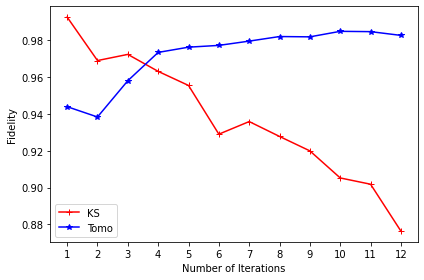

In [51]:
# Compare fidelity, use my own function (when some states from KS are not valid density matrices)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    fed_difference_tomo =  state_fid(total_simu_dens[i].data, tomo_dens[i])
    fed_difference_all =  state_fid(total_simu_dens[i].data, total_smoother_dens[i])
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig("diff_fed.svg")
plt.show()

Iteration 1 KS Fid: 0.9925338505843855 Tomo Fid: 0.9439267525385654
Iteration 2 KS Fid: 0.9689574168714937 Tomo Fid: 0.9383351683741674
Iteration 3 KS Fid: 0.9722995745129427 Tomo Fid: 0.9580231381378862
Iteration 4 KS Fid: 0.963082401049309 Tomo Fid: 0.9733777310343678
Iteration 5 KS Fid: 0.9554438106096184 Tomo Fid: 0.9762134749754922
Iteration 6 KS Fid: 0.9290126839821596 Tomo Fid: 0.9771815180958915
Iteration 7 KS Fid: 0.9358507240073527 Tomo Fid: 0.9795060876865785
Iteration 8 KS Fid: 0.927775251755228 Tomo Fid: 0.9819848464638404
Iteration 9 KS Fid: 0.9199480421966532 Tomo Fid: 0.9818183362758724
Iteration 10 KS Fid: 0.905256293109139 Tomo Fid: 0.9848120553589024
Iteration 11 KS Fid: 0.9018535654035935 Tomo Fid: 0.9846439422139112
Iteration 12 KS Fid: 0.876415668913745 Tomo Fid: 0.9826099900768763


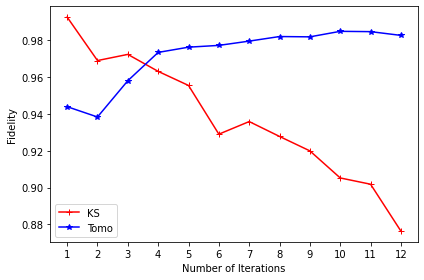

In [52]:
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    fed_difference_tomo =  state_fid(total_simu_dens[i].data, tomo_dens[i])
    fed_difference_all =  state_fid(total_simu_dens[i].data, total_smoother_dens[i])
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig("diff_fed.svg")
plt.show()

Iteration 1 KS Norm: 0.06270318610725441 Tomo Norm: 0.1119452054237083
Iteration 2 KS Norm: 0.12293438451916812 Tomo Norm: 0.12317852605429064
Iteration 3 KS Norm: 0.17060220928097355 Tomo Norm: 0.11450412626498409
Iteration 4 KS Norm: 0.2038920288054609 Tomo Norm: 0.10934272121533715
Iteration 5 KS Norm: 0.2336584634032481 Tomo Norm: 0.09281184690243695
Iteration 6 KS Norm: 0.23767058261506055 Tomo Norm: 0.0921885746002449
Iteration 7 KS Norm: 0.24020552018429273 Tomo Norm: 0.09629385682974839
Iteration 8 KS Norm: 0.2573298385689881 Tomo Norm: 0.09518040428163554
Iteration 9 KS Norm: 0.26626510607957815 Tomo Norm: 0.09442106759611943
Iteration 10 KS Norm: 0.26637038478030106 Tomo Norm: 0.08429190582901182
Iteration 11 KS Norm: 0.28447157744327667 Tomo Norm: 0.0756754017476685
Iteration 12 KS Norm: 0.2788446886272045 Tomo Norm: 0.09371040339354585


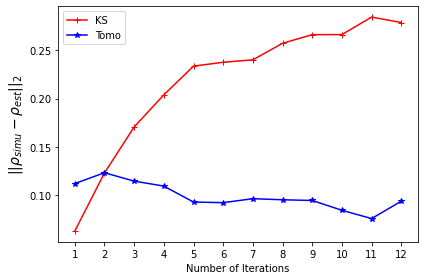

In [53]:
diff_norm_all= []
diff_norm_tomo= []
for i in range(max_num_itrs):
    norm_difference_tomo =  np.linalg.norm(total_simu_dens[i].data-tomo_dens[i])
    norm_difference_all =  np.linalg.norm(total_simu_dens[i].data-total_smoother_dens[i])
    diff_norm_all.append(norm_difference_all)
    diff_norm_tomo.append(norm_difference_tomo)
    print("Iteration",i+1, "KS Norm:", norm_difference_all, "Tomo Norm:", norm_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_norm_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_norm_tomo)[iter_range], '*-', color='blue', label='Tomo')
plt.xlabel("Number of Iterations")
plt.ylabel(r'$||\rho_{simu} - \rho_{est}||_2$', fontsize=14)
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig("diff_norm.svg")
plt.show()

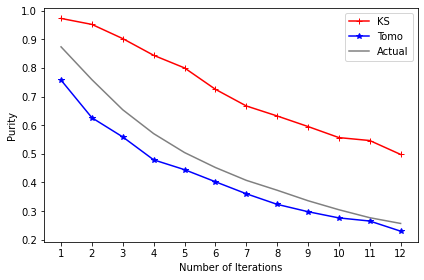

In [54]:
plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.array(tomo_purs)[iter_range], '*-', label="Tomo",color='blue')
# plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range]-0.25, '+-', label="Estimated-0.25",color='skyblue')
plt.plot(np.array(iter_range)+1, np.array(total_simu_purs)[iter_range], label="Actual", color='gray')
plt.xlabel("Number of Iterations")
plt.ylabel("Purity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig("diff_pur.svg")
plt.show()

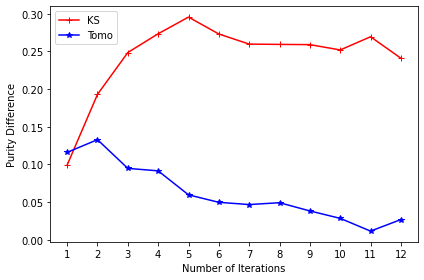

In [45]:
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(total_smoother_purs))[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(tomo_purs))[iter_range], '*-', label="Tomo",color='blue')

plt.xlabel("Number of Iterations")
plt.ylabel("Purity Difference")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig("diff_pur_diff.svg")
plt.show()